In [1]:
# Cell 1: Load default ARC training dataset (train pairs only)
import json, time, random, math, os
from pathlib import Path
from dataclasses import dataclass
from typing import List, Tuple
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Locate default training challenges
start = Path.cwd()
rel = Path('default') / 'arc-agi_training_challenges.json'
train_challenges_path = None
for p in [start, *start.parents]:
    cand = p / rel
    if cand.exists():
        train_challenges_path = cand
        break
if train_challenges_path is None:
    raise FileNotFoundError('Could not locate default training challenges file')
print('Training challenges file:', train_challenges_path)

with train_challenges_path.open('r') as f:
    raw_data = json.load(f)

# Normalize tasks dict
if isinstance(raw_data, list):
    tasks = { (t.get('task_id') or t.get('id') or f'task_{i}') : t for i,t in enumerate(raw_data) }
else:
    tasks = raw_data

pairs = []  # (input_grid, output_grid, task_id, pair_index)
for tid, task in tasks.items():
    for i, pair in enumerate(task.get('train', [])):
        inp = pair.get('input'); out = pair.get('output')
        if inp is None or out is None: continue
        pairs.append((inp, out, tid, i))

print(f'Total train pairs: {len(pairs)} (tasks={len(tasks)})')

# Optional cap for quick experiment
MAX_PAIRS = 500  # set None for full
if MAX_PAIRS and len(pairs) > MAX_PAIRS:
    pairs = pairs[:MAX_PAIRS]
print('Using', len(pairs), 'pairs for training experiment')

Using device: cpu
Training challenges file: c:\Users\aibel\OneDrive\Documents\Code\arc-agi\default\arc-agi_training_challenges.json
Total train pairs: 3232 (tasks=1000)
Using 500 pairs for training experiment


In [2]:
# Cell 2: Dataset + tokenization utilities
PAD, BOS, EOS = 10, 11, 12
VOCAB_SIZE = 13  # digits 0-9 plus PAD,BOS,EOS

def _norm(grid):
    arr = np.array(grid, dtype=int)
    if arr.ndim == 0: arr = arr.reshape(1,1)
    if arr.ndim == 1: arr = arr.reshape(1,-1)
    return arr

def encode_grid(grid):
    g = _norm(grid)
    return g.reshape(-1).tolist()

def decode_grid(tokens, h, w):
    seq = tokens[:h*w]
    return [seq[i*w:(i+1)*w] for i in range(h)]

class PairDataset(Dataset):
    def __init__(self, pairs):  # list of (inp,out,tid,i)
        self.pairs = pairs
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        inp, out, tid, i = self.pairs[idx]
        inp2 = _norm(inp).astype(int)
        out2 = _norm(out).astype(int)
        enc = encode_grid(inp2)
        tgt_core = encode_grid(out2)
        tgt = tgt_core + [EOS]
        dec_in = [BOS] + tgt_core
        return {
            'enc': torch.tensor(enc, dtype=torch.long),
            'dec_in': torch.tensor(dec_in, dtype=torch.long),
            'tgt': torch.tensor(tgt, dtype=torch.long),
            'h_in': inp2.shape[0], 'w_in': inp2.shape[1],
            'h_out': out2.shape[0], 'w_out': out2.shape[1]
        }

def collate(batch):
    B = len(batch)
    enc_lens = [len(b['enc']) for b in batch]
    dec_lens = [len(b['dec_in']) for b in batch]
    max_e = max(enc_lens) if enc_lens else 0
    max_d = max(dec_lens) if dec_lens else 0
    enc = torch.full((B,max_e), PAD, dtype=torch.long)
    dec_in = torch.full((B,max_d), PAD, dtype=torch.long)
    tgt = torch.full((B,max_d), PAD, dtype=torch.long)
    enc_mask = torch.ones((B,max_e), dtype=torch.bool)
    dec_mask = torch.ones((B,max_d), dtype=torch.bool)
    row_idx = torch.zeros((B,max_e), dtype=torch.long)
    col_idx = torch.zeros((B,max_e), dtype=torch.long)
    for i,b in enumerate(batch):
        L_e = len(b['enc']); L_d = len(b['dec_in'])
        enc[i,:L_e] = b['enc']; dec_in[i,:L_d] = b['dec_in']; tgt[i,:len(b['tgt'])]=b['tgt']
        enc_mask[i,:L_e] = False; dec_mask[i,:L_d] = False
        h,w = b['h_in'], b['w_in']
        if h*w == L_e:
            rows = torch.arange(h).repeat_interleave(w)
            cols = torch.arange(w).repeat(h)
            row_idx[i,:L_e] = rows; col_idx[i,:L_e] = cols
    return {'enc':enc,'dec_in':dec_in,'tgt':tgt,'enc_pad_mask':enc_mask,'dec_pad_mask':dec_mask,'row_idx':row_idx,'col_idx':col_idx}

# Split train/val simple
VAL_RATIO = 0.1
cut = int(len(pairs)*(1-VAL_RATIO))
train_pairs = pairs[:cut]
val_pairs = pairs[cut:]

train_ds = PairDataset(train_pairs)
val_ds = PairDataset(val_pairs)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate)
print('Train batches:', len(train_loader), 'Val batches:', len(val_loader))

Train batches: 15 Val batches: 2


In [3]:
# Cell 3: Simple seq2seq Transformer model
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=4096):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(position*div)
        pe[:,1::2] = torch.cos(position*div)
        self.register_buffer('pe', pe.unsqueeze(0), persistent=False)
    def forward(self,x):
        return x + self.pe[:, :x.size(1)]

class ARCSeqModel(nn.Module):
    def __init__(self, vocab=VOCAB_SIZE, d_model=128, nhead=4, layers=3, ff=256, dropout=0.1):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab, d_model)
        self.row_emb = nn.Embedding(64, d_model)
        self.col_emb = nn.Embedding(64, d_model)
        self.pos = PositionalEncoding(d_model)
        enc_layer = nn.TransformerEncoderLayer(d_model, nhead, ff, dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=layers)
        dec_layer = nn.TransformerDecoderLayer(d_model, nhead, ff, dropout, batch_first=True)
        self.decoder = nn.TransformerDecoder(dec_layer, num_layers=layers)
        self.proj = nn.Linear(d_model, vocab)
    def encode(self, batch):
        x = self.tok_emb(batch['enc']) + self.row_emb(batch['row_idx']) + self.col_emb(batch['col_idx'])
        x = self.pos(x)
        x = self.encoder(x, src_key_padding_mask=batch['enc_pad_mask'])
        return x
    def decode(self, ys, memory, dec_pad, enc_pad):
        y = self.tok_emb(ys)
        y = self.pos(y)
        L = y.size(1)
        causal = torch.triu(torch.ones(L,L, device=y.device, dtype=torch.bool),1)
        out = self.decoder(y, memory, tgt_mask=causal, tgt_key_padding_mask=dec_pad, memory_key_padding_mask=enc_pad)
        return self.proj(out)
    def forward(self, batch):
        mem = self.encode(batch)
        return self.decode(batch['dec_in'], mem, batch['dec_pad_mask'], batch['enc_pad_mask'])
    @torch.no_grad()
    def generate(self, batch, max_len=256):
        mem = self.encode(batch)
        B = batch['enc'].size(0)
        ys = torch.full((B,1), BOS, dtype=torch.long, device=mem.device)
        for _ in range(max_len):
            dec_pad = torch.zeros_like(ys, dtype=torch.bool)
            logits = self.decode(ys, mem, dec_pad, batch['enc_pad_mask'])
            nxt = logits[:,-1].argmax(-1, keepdim=True)
            ys = torch.cat([ys, nxt], dim=1)
            if (nxt.squeeze(-1) == EOS).all():
                break
        return ys[:,1:]

model = ARCSeqModel().to(device)
print('Params (M):', sum(p.numel() for p in model.parameters())/1e6)

Params (M): 1.013517


In [4]:
# Cell 4: Training loop
EPOCHS = 5
criterion = nn.CrossEntropyLoss(ignore_index=PAD)
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4, weight_decay=0.01)
from tqdm.auto import tqdm
train_hist = []; val_hist = []
for epoch in range(1, EPOCHS+1):
    model.train(); total=0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch} [train]'):
        for k in batch: batch[k] = batch[k].to(device)
        logits = model(batch)
        B,L,V = logits.shape
        loss = criterion(logits.view(B*L,V), batch['tgt'].view(B*L))
        optimizer.zero_grad(); loss.backward(); nn.utils.clip_grad_norm_(model.parameters(),1.0); optimizer.step()
        total += loss.item()
    train_loss = total / max(1,len(train_loader))
    model.eval(); vtotal=0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f'Epoch {epoch} [val]'):
            for k in batch: batch[k] = batch[k].to(device)
            logits = model(batch)
            B,L,V = logits.shape
            loss = criterion(logits.view(B*L,V), batch['tgt'].view(B*L))
            vtotal += loss.item()
    val_loss = vtotal / max(1,len(val_loader))
    train_hist.append(train_loss); val_hist.append(val_loss)
    print(f'Epoch {epoch}: train_loss={train_loss:.4f} val_loss={val_loss:.4f}')
print('Done.')

c:\Users\aibel\OneDrive\Documents\Code\arc-agi\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Epoch 1 [val]:   0%|          | 0/2 [00:00<?, ?it/s]c:\Users\aibel\OneDrive\Documents\Code\arc-agi\.venv\Lib\site-packages\torch\nn\modules\transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(
c:\Users\aibel\OneDrive\Documents\Code\arc-agi\.venv\Lib\site-packages\torch\nn\modules\transformer.py:515: UserWarning

Epoch 1: train_loss=1.5921 val_loss=1.6665


Epoch 2 [val]: 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


Epoch 2: train_loss=1.0256 val_loss=1.3116


Epoch 3 [val]: 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


Epoch 3: train_loss=0.9176 val_loss=1.2297


Epoch 4 [train]: 100%|██████████| 15/15 [19:02<00:00, 76.17s/it]

Epoch 4 [val]: 100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


Epoch 4: train_loss=0.9041 val_loss=1.1654


Epoch 5 [val]: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]

Epoch 5: train_loss=0.8747 val_loss=1.1361
Done.


In [5]:
# Cell 5: Evaluation metrics & qualitative samples
@torch.no_grad()
def eval_cell_accuracy(model, loader):
    model.eval(); cell_correct=0; cell_total=0; exact=0; total=0
    for batch in loader:
        for k in batch: batch[k] = batch[k].to(device)
        logits = model(batch)
        preds = logits.argmax(-1)
        mask = batch['tgt'] != PAD
        cell_correct += ((preds==batch['tgt']) & mask).sum().item()
        cell_total += mask.sum().item()
        seq_equal = ((preds==batch['tgt']) & mask).sum(1) == mask.sum(1)
        exact += seq_equal.sum().item(); total += preds.size(0)
    return {'cell_acc': cell_correct/max(1,cell_total), 'exact_match': exact/max(1,total)}

metrics = eval_cell_accuracy(model, val_loader)
print('Validation metrics:', metrics)

# Show a few generations
from random import sample as _sample
examples = _sample(train_pairs, min(3,len(train_pairs)))
for inp, out, tid, idx in examples:
    enc_tokens = torch.tensor(encode_grid(inp), dtype=torch.long).unsqueeze(0).to(device)
    h_in,w_in = _norm(inp).shape
    B_enc_mask = torch.zeros_like(enc_tokens, dtype=torch.bool)
    rows = torch.arange(h_in).repeat_interleave(w_in).unsqueeze(0).to(device)
    cols = torch.arange(w_in).repeat(h_in).unsqueeze(0).to(device)
    batch_fake = {'enc':enc_tokens,'row_idx':rows,'col_idx':cols,'enc_pad_mask':B_enc_mask}
    gen = model.generate(batch_fake, max_len=_norm(out).size)
    pred = gen[0].cpu().tolist()
    h_out,w_out = _norm(out).shape
    pred_grid = decode_grid(pred, h_out, w_out)
    print('Task', tid, 'pair', idx)
    print('Input :', inp)
    print('Target:', out)
    print('Pred  :', pred_grid)
    print('-'*50)

Validation metrics: {'cell_acc': 0.6417347580138277, 'exact_match': 0.0}
Task 1f876c06 pair 0
Input : [[9, 0, 0, 0, 0, 0, 0, 3, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 8, 0, 0, 3], [0, 0, 0, 9, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 7, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 8, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 7]]
Target: [[9, 0, 0, 0, 0, 0, 0, 3, 0, 0], [0, 9, 0, 0, 0, 0, 0, 0, 3, 0], [0, 0, 9, 0, 0, 0, 8, 0, 0, 3], [0, 0, 0, 9, 0, 8, 0, 0, 0, 0], [0, 0, 0, 0, 8, 0, 0, 0, 0, 0], [0, 0, 0, 8, 0, 7, 0, 0, 0, 0], [0, 0, 8, 0, 0, 0, 7, 0, 0, 0], [0, 8, 0, 0, 0, 0, 0, 7, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 7, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 7]]
Pred  : [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0,

Task 281123b4 pair 4  | input (4, 19) -> target (4, 4)
- Input grid:
8 8 8 0 3 5 5 5 0 3 9 9 9 0 3 4 4 4 4
8 0 8 0 3 5 5 5 5 3 9 9 0 9 3 0 0 0 0
0 0 0 8 3 5 5 0 0 3 0 0 0 0 3 0 4 4 0
0 8 0 0 3 0 5 5 5 3 9 0 0 0 3 4 4 4 4
- Target grid:
9 9 9 4
9 9 8 9
5 4 4 8
9 4 4 4
- Predicted grid (mismatches highlighted):
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0


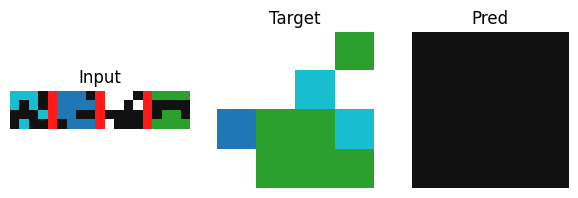

Per-example cell accuracy: 0/16 = 0.00%
Task 29623171 pair 0  | input (11, 11) -> target (11, 11)
- Input grid:
0 0 0 5 0 2 0 5 2 0 0
2 0 0 5 0 0 0 5 0 0 2
0 0 0 5 0 0 0 5 0 0 0
5 5 5 5 5 5 5 5 5 5 5
2 0 0 5 0 0 0 5 0 0 0
2 0 0 5 0 0 2 5 0 0 0
0 0 0 5 0 0 0 5 0 2 0
5 5 5 5 5 5 5 5 5 5 5
0 0 0 5 0 0 0 5 0 0 0
2 0 0 5 0 0 2 5 0 0 2
0 0 0 5 0 0 0 5 0 0 0
- Target grid:
0 0 0 5 0 0 0 5 2 2 2
0 0 0 5 0 0 0 5 2 2 2
0 0 0 5 0 0 0 5 2 2 2
5 5 5 5 5 5 5 5 5 5 5
2 2 2 5 0 0 0 5 0 0 0
2 2 2 5 0 0 0 5 0 0 0
2 2 2 5 0 0 0 5 0 0 0
5 5 5 5 5 5 5 5 5 5 5
0 0 0 5 0 0 0 5 0 0 0
0 0 0 5 0 0 0 5 0 0 0
0 0 0 5 0 0 0 5 0 0 0
- Predicted grid (mismatches highlighted):
0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0


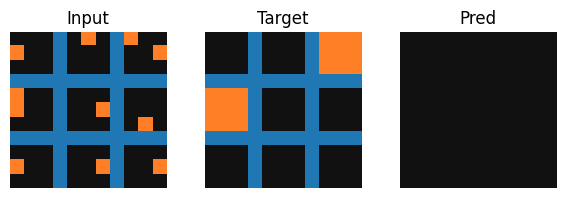

Per-example cell accuracy: 63/121 = 52.07%
Task 29623171 pair 1  | input (11, 11) -> target (11, 11)
- Input grid:
0 0 0 5 0 0 0 5 0 0 0
1 0 0 5 0 0 0 5 0 1 0
0 0 0 5 0 0 1 5 0 0 0
5 5 5 5 5 5 5 5 5 5 5
0 0 0 5 0 0 1 5 0 0 0
0 0 0 5 0 0 0 5 0 1 0
0 0 0 5 0 0 0 5 0 0 0
5 5 5 5 5 5 5 5 5 5 5
0 0 0 5 0 0 0 5 1 0 0
0 1 0 5 0 0 0 5 0 0 1
0 0 0 5 0 0 0 5 0 0 0
- Target grid:
0 0 0 5 0 0 0 5 0 0 0
0 0 0 5 0 0 0 5 0 0 0
0 0 0 5 0 0 0 5 0 0 0
5 5 5 5 5 5 5 5 5 5 5
0 0 0 5 0 0 0 5 0 0 0
0 0 0 5 0 0 0 5 0 0 0
0 0 0 5 0 0 0 5 0 0 0
5 5 5 5 5 5 5 5 5 5 5
0 0 0 5 0 0 0 5 1 1 1
0 0 0 5 0 0 0 5 1 1 1
0 0 0 5 0 0 0 5 1 1 1
- Predicted grid (mismatches highlighted):
0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0


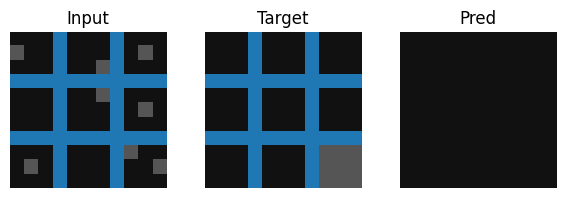

Per-example cell accuracy: 72/121 = 59.50%
Task 2a5f8217 pair 0  | input (9, 9) -> target (9, 9)
- Input grid:
0 0 0 0 0 0 0 0 0
0 1 1 1 0 0 1 0 0
0 1 0 1 0 0 1 1 0
0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 9 9
0 0 1 1 0 0 0 0 9
0 0 0 1 0 7 0 0 0
6 6 6 0 0 7 7 0 0
6 0 6 0 0 0 0 0 0
- Target grid:
0 0 0 0 0 0 0 0 0
0 6 6 6 0 0 7 0 0
0 6 0 6 0 0 7 7 0
0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 9 9
0 0 9 9 0 0 0 0 9
0 0 0 9 0 7 0 0 0
6 6 6 0 0 7 7 0 0
6 0 6 0 0 0 0 0 0
- Predicted grid (mismatches highlighted):
0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0


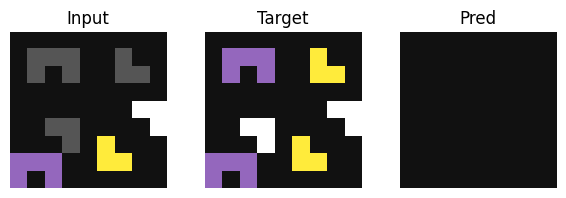

Per-example cell accuracy: 59/81 = 72.84%
Task 27a28665 pair 5  | input (3, 3) -> target (1, 1)
- Input grid:
4 4 0
4 0 4
0 4 0
- Target grid:
1
- Predicted grid (mismatches highlighted):
0


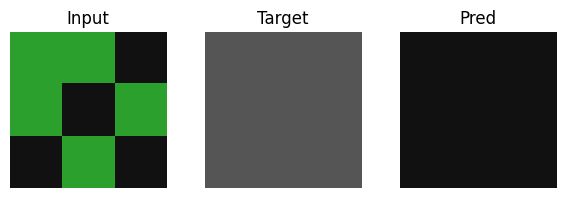

Per-example cell accuracy: 0/1 = 0.00%


In [6]:
# Cell 6: Visualize predictions vs targets (grid view)
import random, shutil

# ANSI color palette for digits 0-9 (background colors) + reset
_ANSI_BG = [
    "\x1b[48;5;232m",  # 0 nearly black
    "\x1b[48;5;240m",  # 1 dark gray
    "\x1b[48;5;202m",  # 2 orange
    "\x1b[48;5;196m",  # 3 red
    "\x1b[48;5;34m",   # 4 green
    "\x1b[48;5;27m",   # 5 blue
    "\x1b[48;5;93m",   # 6 purple
    "\x1b[48;5;226m",  # 7 yellow
    "\x1b[48;5;39m",   # 8 cyan
    "\x1b[48;5;15m"    # 9 white
]
_RESET = "\x1b[0m"

def color_cell(v, mismatch=False):
    v = int(v) if 0 <= int(v) <= 9 else 0
    bg = _ANSI_BG[v]
    # Show digit centered; highlight mismatch with bold inverse border effect (use bright fg)
    if mismatch:
        return f"\x1b[1m{bg}\x1b[38;5;196m{v}\x1b[0m"
    else:
        return f"{bg}{v}\x1b[0m"

def render_grid(grid, ref=None):
    g = _norm(grid)
    lines = []
    for r in range(g.shape[0]):
        row_cells = []
        for c in range(g.shape[1]):
            mismatch = False
            if ref is not None:
                mismatch = (g[r,c] != ref[r][c])
            row_cells.append(color_cell(g[r,c], mismatch))
        lines.append(' '.join(row_cells) + _RESET)
    return '\n'.join(lines)

try:
    import matplotlib.pyplot as plt
    _HAS_MPL = True
except Exception:
    _HAS_MPL = False

if _HAS_MPL:
    # Define a simple color map for 0-9
    import numpy as np
    from matplotlib.colors import ListedColormap
    cmap = ListedColormap([
        '#111111', '#555555', '#ff7f27', '#ff1a1a', '#2ca02c', '#1f77b4', '#9467bd', '#ffeb3b', '#17becf', '#ffffff'
    ])

@torch.no_grad()
def visualize_predictions(n=5, use_validation=True, max_gen_len=256):
    if use_validation and len(val_pairs)==0:
        print('No validation split; falling back to training pairs.')
        use_validation = False
    pool = val_pairs if use_validation else train_pairs
    if len(pool)==0:
        print('No pairs to visualize.')
        return
    sample = random.sample(pool, min(n, len(pool)))
    for inp, out, tid, idx in sample:
        inp_arr = _norm(inp)
        out_arr = _norm(out)
        enc_tokens = torch.tensor(encode_grid(inp_arr), dtype=torch.long).unsqueeze(0).to(device)
        rows = torch.arange(inp_arr.shape[0]).repeat_interleave(inp_arr.shape[1]).unsqueeze(0).to(device)
        cols = torch.arange(inp_arr.shape[1]).repeat(inp_arr.shape[0]).unsqueeze(0).to(device)
        enc_pad = torch.zeros_like(enc_tokens, dtype=torch.bool)
        batch_fake = {'enc':enc_tokens,'row_idx':rows,'col_idx':cols,'enc_pad_mask':enc_pad}
        gen = model.generate(batch_fake, max_len=min(max_gen_len, out_arr.size))
        pred = gen[0].cpu().tolist()
        pred_grid = decode_grid(pred, out_arr.shape[0], out_arr.shape[1])
        # Text / ANSI output
        print('='*70)
        print(f'Task {tid} pair {idx}  | input {inp_arr.shape} -> target {out_arr.shape}')
        print('- Input grid:')
        print(render_grid(inp_arr))
        print('- Target grid:')
        print(render_grid(out_arr))
        print('- Predicted grid (mismatches highlighted):')
        print(render_grid(pred_grid, ref=out_arr))
        # Optional matplotlib side-by-side for richer view
        if _HAS_MPL:
            fig, axs = plt.subplots(1,3, figsize=(6,2))
            axs[0].imshow(inp_arr, cmap=cmap, vmin=0, vmax=9); axs[0].set_title('Input'); axs[0].axis('off')
            axs[1].imshow(out_arr, cmap=cmap, vmin=0, vmax=9); axs[1].set_title('Target'); axs[1].axis('off')
            axs[2].imshow(np.array(pred_grid), cmap=cmap, vmin=0, vmax=9); axs[2].set_title('Pred'); axs[2].axis('off')
            plt.tight_layout(); plt.show()
        # Simple accuracy for this example
        match = sum(pred_grid[r][c] == out_arr[r,c] for r in range(out_arr.shape[0]) for c in range(out_arr.shape[1]))
        total = out_arr.shape[0]*out_arr.shape[1]
        print(f'Per-example cell accuracy: {match}/{total} = {match/total:.2%}')

# Run visualization on (up to) 5 validation examples
visualize_predictions(n=5, use_validation=True)
